## EXPLORING mfcc_features

In [10]:
import sys
!{sys.executable} -m pip install librosa


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import numpy as np
import pandas as pd

In [14]:
data = np.load("../features/mfcc_features.npz")
print(data.files) 

['X', 'y']


In [15]:
X = data['X']  
y = data['y']  
print("Original shape:", X.shape)
# print("Original shape:", y.shape)

Original shape: (7994, 40)


### have total of 7994 samples and 40 features 
### Next extracting MFCC features (from .mp3 to .npy file)

In [16]:
SOURCE_DIR = '../musicData/fma_small/'
DEST_DIR = '../features/lstm_mfcc'

# number of audio samples per second, to resample file to a smaller size and processing time while retaining enough frequency
SAMPLE_RATE = 22050

# MFCC Coefficients(Mel-Frequency Cepstral Coefficients) to extract per time frame
N_MFCC = 20
# The number of time frames per audio clip you want.
MAX_LEN = 130

os.makedirs(DEST_DIR, exist_ok=True)

def extract_mfcc(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)

        if mfcc.shape[1] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LEN - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]

        return mfcc.T  

    except Exception as e:
        print(f"Failed: {file_path} → {e}")
        return None

def process_all_files():
    count = 0
    print(f"Walking through: {SOURCE_DIR}")
    for root, _, files in os.walk(SOURCE_DIR):
        for fname in files:
            if fname.lower().endswith(".mp3"):  # case-insensitive
                full_path = os.path.join(root, fname)
                mfcc = extract_mfcc(full_path)
                if mfcc is not None:
                    out_name = os.path.splitext(fname)[0] + ".npy"
                    save_path = os.path.join(DEST_DIR, out_name)
                    np.save(save_path, mfcc)
                    print(f" Saved: {save_path}")
                    count += 1
    print(f"\n Done. Total processed: {count}")


process_all_files()

Walking through: ../musicData/fma_small/

 Done. Total processed: 0


In [17]:
genre_df = pd.read_csv("../reports/step_1_Explore_Metadata/valid_track_genres.csv")

# Get unique genres and assign integer labels
unique_genres = sorted(genre_df['genre_top'].dropna().unique())
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}

# Map each track_id to a label
label_map = {
    row['track_id']: genre_to_id[row['genre_top']]
    for _, row in genre_df.iterrows()
}

print("Genre → ID mapping:")
print(genre_to_id)
print(f"Total labeled tracks: {len(label_map)}")


Genre → ID mapping:
{'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
Total labeled tracks: 8000


In [18]:
import os

npy_files = os.listdir('../features/lstm_mfcc')
print("Sample .npy files:", npy_files[:5])


Sample .npy files: ['000002.npy', '000005.npy', '000010.npy', '000140.npy', '000141.npy']


In [19]:
class FMA_LSTM_Dataset(Dataset):
    def __init__(self, feature_dir, label_map):
        self.feature_dir = feature_dir
        self.label_map = label_map
        self.file_list = [
            f for f in os.listdir(feature_dir)
            if f.endswith(".npy") and int(os.path.splitext(f)[0]) in label_map
        ]
        print(f"Total .npy files with labels found: {len(self.file_list)}")
        print("Example file_list content:", self.file_list[:5])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        track_id = int(os.path.splitext(filename)[0])
        label = self.label_map[track_id]

        mfcc_path = os.path.join(self.feature_dir, filename)
        x = np.load(mfcc_path)  # shape: (130, 20)
        # normalizing to avoid divide by 0
        x = (x - np.mean(x)) / (np.std(x) + 1e-8) 
        
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return x_tensor, y_tensor

In [20]:
dataset = FMA_LSTM_Dataset(
    feature_dir='../features/lstm_mfcc',
    label_map=label_map
)

# Sanity check
print(len(dataset))
x, y = dataset[0]
print("MFCC shape:", x.shape)   # (130, 20)
print("Genre class:", y)

Total .npy files with labels found: 7997
Example file_list content: ['000002.npy', '000005.npy', '000010.npy', '000140.npy', '000141.npy']
7997
MFCC shape: torch.Size([130, 20])
Genre class: tensor(3)


In [21]:
## test train split

In [22]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)
x_batch, y_batch = next(iter(train_loader))
# print("Batch shape:", x_batch.shape)  
# print("Genre class labels:", y_batch[:5])

In [23]:
# creating custom NN which will be used
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=20, hidden_size=128, num_layers=3, num_classes=8, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                           bidirectional=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (hn, _) = self.lstm(x)       
        logits = self.fc(hn[-1])          
        return logits


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(num_classes=len(set(label_map.values())))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [26]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1/20
  Train Loss: 1.9657, Accuracy: 0.2306
  Val   Loss: 1.9078, Accuracy: 0.2544
Epoch 2/20
  Train Loss: 1.8809, Accuracy: 0.2900
  Val   Loss: 1.8628, Accuracy: 0.2869
Epoch 3/20
  Train Loss: 1.8401, Accuracy: 0.3055
  Val   Loss: 1.8165, Accuracy: 0.3125
Epoch 4/20
  Train Loss: 1.8145, Accuracy: 0.3111
  Val   Loss: 1.8166, Accuracy: 0.3144
Epoch 5/20
  Train Loss: 1.7799, Accuracy: 0.3259
  Val   Loss: 1.8087, Accuracy: 0.3194
Epoch 6/20
  Train Loss: 1.7693, Accuracy: 0.3314
  Val   Loss: 1.7654, Accuracy: 0.3412
Epoch 7/20
  Train Loss: 1.7347, Accuracy: 0.3470
  Val   Loss: 1.7461, Accuracy: 0.3463
Epoch 8/20
  Train Loss: 1.7081, Accuracy: 0.3570
  Val   Loss: 1.7310, Accuracy: 0.3606
Epoch 9/20
  Train Loss: 1.6965, Accuracy: 0.3633
  Val   Loss: 1.7379, Accuracy: 0.3800
Epoch 10/20
  Train Loss: 1.6551, Accuracy: 0.3808
  Val   Loss: 1.7335, Accuracy: 0.3375
Epoch 11/20
  Train Loss: 1.6505, Accuracy: 0.3808
  Val   Loss: 1.7150, Accuracy: 0.3631
Epoch 12/20
  Train

In [27]:
torch.save(model.state_dict(), '../models/lstm_genre_classifier_without_class_weights.pth') 

In [29]:
map_loc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(
    '../models/lstm_genre_classifier.pth', map_location=map_loc))
model.to(device)
model.eval()

LSTMClassifier(
  (lstm): LSTM(20, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [30]:
y_preds = []
y_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1)

        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

from sklearn.metrics import classification_report
genre_id_to_name = {
    0: 'Electronic',
    1: 'Experimental',
    2: 'Folk',
    3: 'Hip-Hop',
    4: 'Instrumental',
    5: 'International',
    6: 'Pop',
    7: 'Rock'
}

print(classification_report(
    y_true,
    y_preds,
    target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
))


               precision    recall  f1-score   support

   Electronic       0.00      0.00      0.00       199
 Experimental       0.00      0.00      0.00       205
         Folk       0.13      1.00      0.23       203
      Hip-Hop       0.00      0.00      0.00       206
 Instrumental       0.00      0.00      0.00       194
International       0.00      0.00      0.00       189
          Pop       0.00      0.00      0.00       208
         Rock       0.00      0.00      0.00       196

     accuracy                           0.13      1600
    macro avg       0.02      0.12      0.03      1600
 weighted avg       0.02      0.13      0.03      1600



c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [31]:
with open('../reports/lstm_mfcc/lstm_classification_report_without_class_weights.txt', 'w') as f:
    f.write(classification_report(
        y_true,
        y_preds,
        target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
    ))

c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

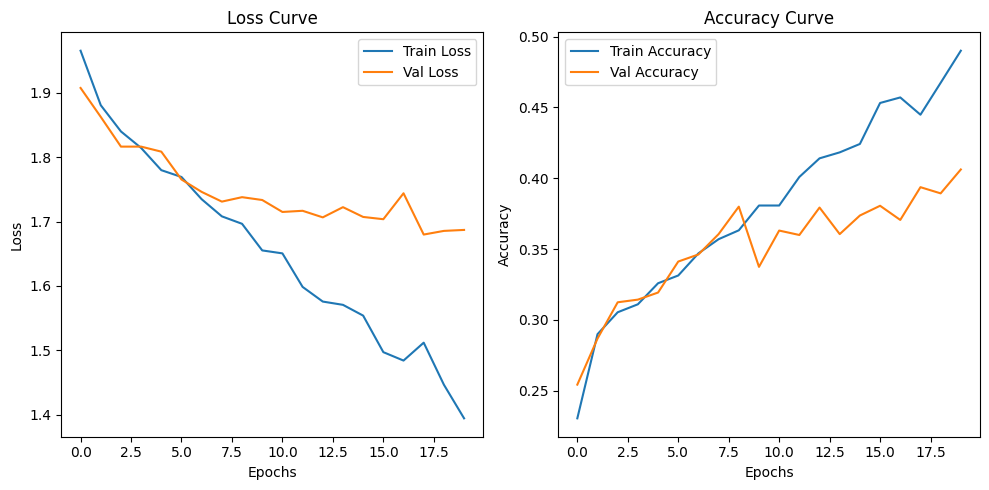

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
from collections import Counter

# Extract class labels from train_set
train_labels = [label.item() if torch.is_tensor(label) else label for _, label in train_set]

# Count frequency of each class
label_counts = Counter(train_labels)

print("Train class distribution:")
for class_id, count in sorted(label_counts.items()):
    print(f"Class {class_id}: {count} samples")

Train class distribution:
Class 0: 800 samples
Class 1: 794 samples
Class 2: 797 samples
Class 3: 794 samples
Class 4: 806 samples
Class 5: 811 samples
Class 6: 792 samples
Class 7: 803 samples


### The above results we can clearly interpret the following
- **Precision = 0.00 for 7/8 classes:**  Model never predicted those classes at all.
- **Recall = 1.00 for Folk only:** Model predicted only 'Folk' — for every input
- **LSTM is biased towards a single class "Folk"**. Failing to learn useful decision boundaries between genres could be due to multiple reasons like, difficulty in learning MFCC patterns by model, model might be overfitting certain temporal patterns, loss function "CrossEntropyLoss" treats all errors equally and missclassification gets no penalty.
### Solution: 
using class_weights in cross entropy

In [34]:
# Extract true labels from the train set
y_train_labels = [y for _, y in train_set]
y_train_labels = [label.item() if torch.is_tensor(label) else label for label in y_train_labels]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
print("Class weights:", class_weights)
# Convert to torch tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Class weights: [0.99953125 1.00708438 1.0032936  1.00708438 0.99209057 0.98597411
 1.00962753 0.99579701]


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(num_classes=len(set(label_map.values())))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [39]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

Epoch 1/2
  Train Loss: 1.9339, Accuracy: 0.2553
  Val   Loss: 1.9107, Accuracy: 0.2781
Epoch 2/2
  Train Loss: 1.9310, Accuracy: 0.2575
  Val   Loss: 1.9027, Accuracy: 0.2769


In [ ]:
torch.save(model.state_dict(), '../models/lstm_genre_classifier_with_class_weights.pth') 

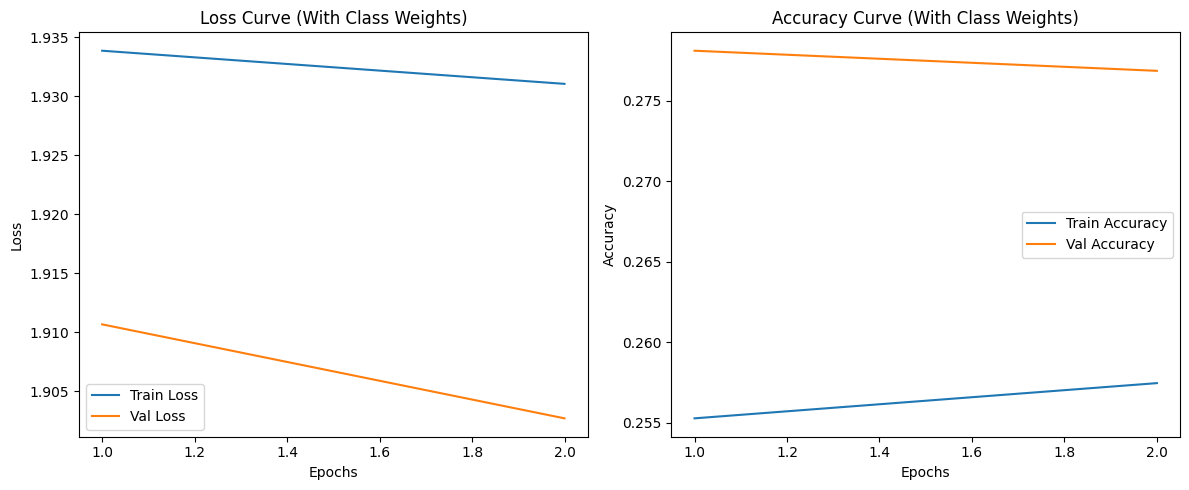

In [40]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve (With Class Weights)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve (With Class Weights)')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Classification Report
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1)

        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

genre_id_to_name = {
    0: 'Electronic',
    1: 'Experimental',
    2: 'Folk',
    3: 'Hip-Hop',
    4: 'Instrumental',
    5: 'International',
    6: 'Pop',
    7: 'Rock'
}

class_names = [genre_id_to_name[i] for i in sorted(genre_id_to_name)]
print(classification_report(
    y_true,
    y_preds,
    target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
))

               precision    recall  f1-score   support

   Electronic       0.50      0.01      0.02       199
 Experimental       0.20      0.01      0.02       205
         Folk       0.21      0.32      0.26       203
      Hip-Hop       0.31      0.26      0.28       206
 Instrumental       0.29      0.50      0.37       194
International       0.22      0.51      0.31       189
          Pop       0.50      0.01      0.02       208
         Rock       0.38      0.64      0.48       196

     accuracy                           0.28      1600
    macro avg       0.33      0.28      0.22      1600
 weighted avg       0.33      0.28      0.21      1600



In [42]:
with open('../reports/lstm_mfcc/lstm_classification_report_with_class_weights.txt', 'w') as f:
    f.write(classification_report(
        y_true,
        y_preds,
        target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
    ))

In [43]:
## confusion matrix

In [46]:
def evaluate_and_plot(model_path, model_label):
    # Reload model
    model = LSTMClassifier(input_size=20, hidden_size=128, num_layers=3, num_classes=8, dropout=0.3)
    map_loc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=map_loc))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_label}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'../reports/lstm_mfcc/confusion_matrix_{model_label.replace(" ", "_").lower()}.png')
    plt.show()

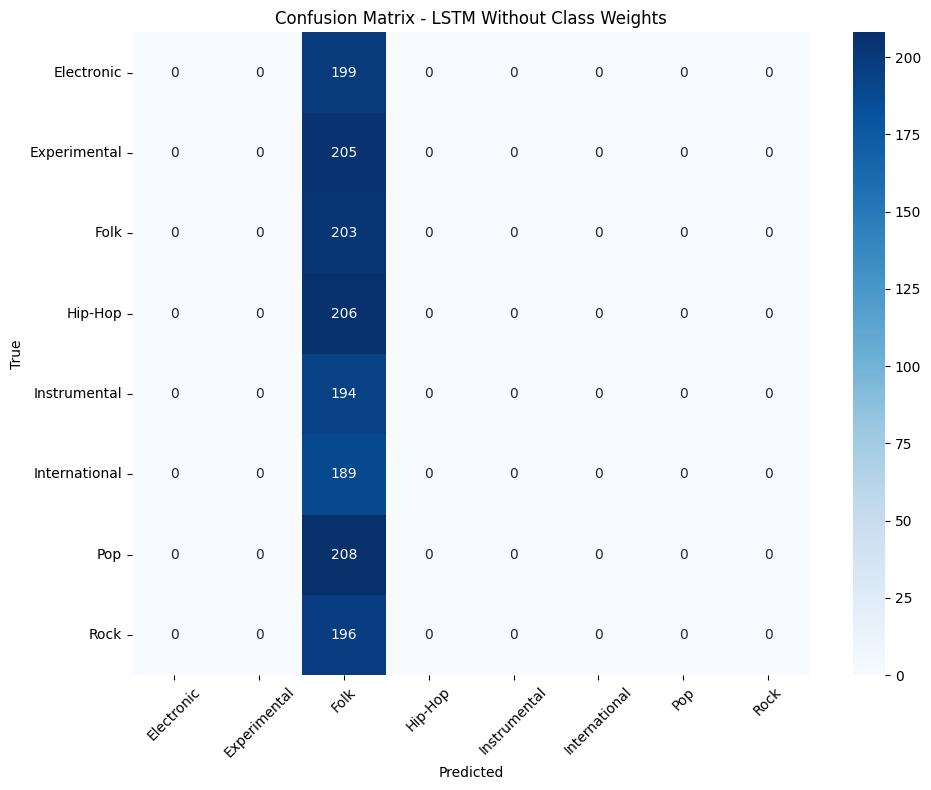

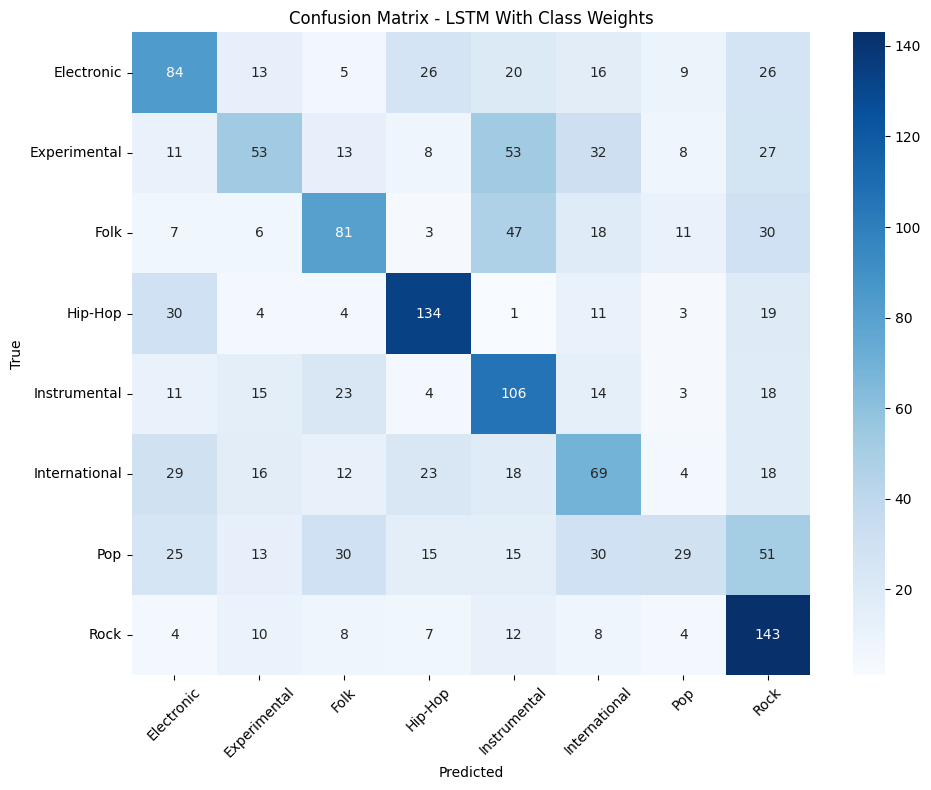

In [47]:
evaluate_and_plot('../models/lstm_genre_classifier.pth', 'LSTM Without Class Weights')
evaluate_and_plot('../models/lstm_genre_classifier_with_class_weights.pth', 'LSTM With Class Weights')

### Without class weights, the LSTM defaulted to predicting “Folk” for all samples, leading to high validation accuracy but meaningless classification. After adding class weights to penalize misclassification across all genres equally, the model began to meaningfully differentiate between genres, as reflected in the improved diagonal strength in the confusion matrix and balanced class-wise metrics